In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

from basic_artificial_market import ArtificialMarket

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math

class TwoHFTMarket():
    def __init__(self, num_player=1000, fdmtl=10000.0, ganma=1, sigma=0.06, P_sigma=30):
        self.num_player = num_player
        self.random_state = np.random.RandomState()
        self.fdmtl = fdmtl
        self.sigma = sigma
        self.P_sigma = P_sigma
    
    def weight(self, w_1_max=1, w_2_max=10, w_3_max=1, w_4_max=5):
        num_player = self.num_player
        weight_1 = np.zeros(num_player)
        weight_2 = np.zeros(num_player)
        weight_3 = np.zeros(num_player)
        weight_4 = np.zeros(num_player)
        random_state = self.random_state
        for i in range(num_player):
            weight_1[i] = random_state.uniform()*w_1_max
            weight_2[i] = random_state.uniform()*w_2_max
            weight_3[i] = random_state.uniform()*w_3_max
            weight_4[i] = random_state.uniform()*w_4_max
        weight = [weight_1, weight_2, weight_3,  weight_4]
        return weight
    
    def ganma(self, ganma_max=10000, num_player=None):
        random_state = self.random_state
        if num_player is None:
            num_player = self.num_player
        ganma = np.array([])
        for i in range(num_player):
            ganma = np.append(ganma, int(random_state.uniform(ganma_max)))
        return ganma
    
    def P_t(self, past_data, delta_l, delta_t):
        if np.sum(delta_t) <= delta_l:
            P_t = past_data[-1]
        else: 
            d = 0
            j = 0
            while d <= delta_l:
                j += 1
                d += delta_t[-j]
            P_t = past_data[-j]
        return P_t
    
    def r_t_h(self, past_data, P_t, ganma):
        if len(past_data) < ganma:
            past_data_ganma = past_data[0]
            r_t_h = np.log(P_t/past_data_ganma)
        else:
            past_data_ganma = past_data[-ganma]
            r_t_h = np.log(P_t/past_data_ganma)
        return r_t_h

    def one_market_model(self, w, delta_l=0, past_data=None, delta_t=None, b_limit=None, s_limit=None, ganma_max=10, market_order=0, nottrading=False):
        delta = 1
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = self.fdmtl
        
        if past_data is None:
            past_data = [P_f]
        if b_limit is None:
            b_limit = []
        if s_limit is None:
            s_limit = []
        if delta_t is None:
            delta_t = np.array([])
            
        P_t_1 = past_data[-1]
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        
        r_t_e = np.zeros(num_player)
        
        ganma = self.ganma()
    
        for i in range(num_player):
            P_t_1 = self.P_t(past_data, delta_l, delta_t)
            
            r_t_h = self.r_t_h(past_data, P_t_1, ganma[i]) 
            
            e_t = np.random.normal(0, sigma)
            r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t)/(w_1[i] + w_2[i] + w_3[i])
            
            P_e = P_t_1*math.exp(r_t_e[i])
            P_o = np.random.normal(P_e, P_sigma)
            
            if nottrading is True:
                P_e = 10000
            
            if P_e > P_o:
                P_o = round(P_o, 1)
                if len(s_limit) > 0 and np.min(s_limit) < P_o and nottrading is False:
                    P_t = np.min(s_limit)
                    s_limit = np.delete(s_limit, np.argmin(s_limit))
                    market_order += 1
                else:
                    b_limit = np.append(b_limit, P_o)
                    P_t = P_t_1
            else:
                P_o = round(P_o, 1)+0.1
                if len(b_limit) > 0 and np.max(b_limit) > P_o and nottrading is False:
                    P_t = np.max(b_limit)
                    b_limit = np.delete(b_limit, np.argmax(b_limit))
                    market_order += 1
                else:
                    s_limit = np.append(s_limit, P_o)
                    P_t = P_t_1
            past_data = np.append(past_data, P_t)
            delta_t = np.append(delta_t, np.random.exponential(delta))
        return past_data, delta_t, b_limit, s_limit, market_order
        
    def one_market_simulation(self, delta_l=0, t_max=100000, fdmtl=10000.0):
        w = self.weight()
        t = 0
        for i in range(2):
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, nottrading=True)
        past_data = np.array([fdmtl])
        delta_t = np.array([0])
        while t < t_max:
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, past_data, delta_t, b_limit, s_limit, market_order)
            t = len(delta_t)
        return past_data, market_order
    
    def budish_model(self, w, delta_l=0, past_data_1=None, past_data_2=None, delta_t=None, b_limit_1=None, b_limit_2=None, s_limit_1=None, s_limit_2=None, ganma_max=10, market_order=0, nottrading=False):
        delta = 1
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = self.fdmtl
        
        if past_data_1 is None:
            past_data_1 = [P_f]
        if past_data_2 is None:
            past_data_2 = [P_f]
        if b_limit_1 is None:
            b_limit_1 = []
        if s_limit_1 is None:
            s_limit_1 = []
        if b_limit_2 is None:
            b_limit_2 = []
        if s_limit_2 is None:
            s_limit_2 = []
        if delta_t is None:
            delta_t = np.array([])
            
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        w_4 = w[3]
        
        r_t_e = np.zeros(num_player)
        
        ganma = self.ganma()
    
        for i in range(num_player):
            o = np.random.choice([1, 2])
            
            if o == 1:
                
                P_t_1 = self.P_t(past_data_1, delta_l, delta_t)

                r_t_h_co = self.r_t_h(past_data_2, P_t_1, ganma[i])

                r_t_h = self.r_t_h(past_data_1, P_t_1, ganma[i]) 

                e_t = np.random.normal(0, sigma)
                r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t + w_4[i]*r_t_h_co)/(w_1[i] + w_2[i] + w_3[i] +  w_4[i])

                P_e = P_t_1*math.exp(r_t_e[i])
                P_o = np.random.normal(P_e, P_sigma)

                if nottrading is True:
                    P_e = 10000

                if P_e > P_o:
                    P_o = round(P_o, 1)
                    if len(s_limit_1) > 0 and np.min(s_limit_1) < P_o and nottrading is False:
                        P_t = np.min(s_limit_1)
                        s_limit_1 = np.delete(s_limit_1, np.argmin(s_limit_1))
                        market_order += 1
                    else:
                        b_limit_1 = np.append(b_limit_1, P_o)
                        P_t = P_t_1
                else:
                    P_o = round(P_o, 1)+0.1
                    if len(b_limit_1) > 0 and np.max(b_limit_1) > P_o and nottrading is False:
                        P_t = np.max(b_limit_1)
                        b_limit_1 = np.delete(b_limit_1, np.argmax(b_limit_1))
                        market_order += 1
                    else:
                        s_limit_1 = np.append(s_limit_1, P_o)
                        P_t = P_t_1
                past_data_1 = np.append(past_data_1, P_t)

                r_t_h_co = r_t_h

                P_t_1 = self.P_t(past_data_2, delta_l, delta_t)

                r_t_h = self.r_t_h(past_data_2, P_t_1, ganma[i]) 

                e_t = np.random.normal(0, sigma)
                r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t + w_4[i]*r_t_h_co)/(w_1[i] + w_2[i] + w_3[i] +  w_4[i])

                P_e = P_t_1*math.exp(r_t_e[i])
                P_o = np.random.normal(P_e, P_sigma)

                if nottrading is True:
                    P_e = 10000

                if P_e > P_o:
                    P_o = round(P_o, 1)
                    if len(s_limit_2) > 0 and np.min(s_limit_2) < P_o and nottrading is False:
                        P_t = np.min(s_limit_2)
                        s_limit_2 = np.delete(s_limit_2, np.argmin(s_limit_2))
                        market_order += 1
                    else:
                        b_limit_2 = np.append(b_limit_2, P_o)
                        P_t = P_t_1
                else:
                    P_o = round(P_o, 1)+0.1
                    if len(b_limit_2) > 0 and np.max(b_limit_2) > P_o and nottrading is False:
                        P_t = np.max(b_limit_2)
                        b_limit_2 = np.delete(b_limit_2, np.argmax(b_limit_2))
                        market_order += 1
                    else:
                        s_limit_2 = np.append(s_limit_2, P_o)
                        P_t = P_t_1
                past_data_2 = np.append(past_data_2, P_t)
                delta_t = np.append(delta_t, np.random.exponential(delta))
            
            else:

                P_t_1 = self.P_t(past_data_2, delta_l, delta_t)
                
                r_t_h_co = self.r_t_h(past_data_1, P_t_1, ganma[i])

                r_t_h = self.r_t_h(past_data_2, P_t_1, ganma[i]) 

                e_t = np.random.normal(0, sigma)
                r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t + w_4[i]*r_t_h_co)/(w_1[i] + w_2[i] + w_3[i] +  w_4[i])

                P_e = P_t_1*math.exp(r_t_e[i])
                P_o = np.random.normal(P_e, P_sigma)

                if nottrading is True:
                    P_e = 10000

                if P_e > P_o:
                    P_o = round(P_o, 1)
                    if len(s_limit_2) > 0 and np.min(s_limit_2) < P_o and nottrading is False:
                        P_t = np.min(s_limit_2)
                        s_limit_2 = np.delete(s_limit_2, np.argmin(s_limit_2))
                        market_order += 1
                    else:
                        b_limit_2 = np.append(b_limit_2, P_o)
                        P_t = P_t_1
                else:
                    P_o = round(P_o, 1)+0.1
                    if len(b_limit_2) > 0 and np.max(b_limit_2) > P_o and nottrading is False:
                        P_t = np.max(b_limit_2)
                        b_limit_2 = np.delete(b_limit_2, np.argmax(b_limit_2))
                        market_order += 1
                    else:
                        s_limit_2 = np.append(s_limit_2, P_o)
                        P_t = P_t_1
                past_data_2 = np.append(past_data_2, P_t)
                
                P_t_1 = self.P_t(past_data_1, delta_l, delta_t)
            
                r_t_h_co = r_t_h

                r_t_h = self.r_t_h(past_data_1, P_t_1, ganma[i]) 

                e_t = np.random.normal(0, sigma)
                r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t + w_4[i]*r_t_h_co)/(w_1[i] + w_2[i] + w_3[i] +  w_4[i])

                P_e = P_t_1*math.exp(r_t_e[i])
                P_o = np.random.normal(P_e, P_sigma)

                if nottrading is True:
                    P_e = 10000

                if P_e > P_o:
                    P_o = round(P_o, 1)
                    if len(s_limit_1) > 0 and np.min(s_limit_1) < P_o and nottrading is False:
                        P_t = np.min(s_limit_1)
                        s_limit_1 = np.delete(s_limit_1, np.argmin(s_limit_1))
                        market_order += 1
                    else:
                        b_limit_1 = np.append(b_limit_1, P_o)
                        P_t = P_t_1
                else:
                    P_o = round(P_o, 1)+0.1
                    if len(b_limit_1) > 0 and np.max(b_limit_1) > P_o and nottrading is False:
                        P_t = np.max(b_limit_1)
                        b_limit_1 = np.delete(b_limit_1, np.argmax(b_limit_1))
                        market_order += 1
                    else:
                        s_limit_1 = np.append(s_limit_1, P_o)
                        P_t = P_t_1
                past_data_1 = np.append(past_data_1, P_t)
                delta_t = np.append(delta_t, np.random.exponential(delta))
            
        return past_data_1, past_data_2, delta_t, b_limit_1, b_limit_2, s_limit_1, s_limit_2, market_order
        
    def one_market_simulation(self, delta_l=0, t_max=100000, fdmtl=10000.0):
        w = self.weight()
        t = 0
        for i in range(2):
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, nottrading=True)
        past_data = np.array([fdmtl])
        delta_t = np.array([0])
        while t < t_max:
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, past_data, delta_t, b_limit, s_limit, market_order)
            t = len(delta_t)
        return past_data, market_order
    
    def two_market_simulation(self, delta_l=0, t_max=100000, fdmtl=10000.0):
        w = self.weight()
        t = 0
        for i in range(2):
            past_data_1, past_data_2, delta_t, b_limit_1, b_limit_2, s_limit_1, s_limit_2, market_order = self.budish_model(w, delta_l, nottrading=True)
        past_data_1 = np.array([fdmtl])
        past_data_2 = np.array([fdmtl])
        delta_t = np.array([0])
        while t < t_max:
            past_data_1, past_data_2, delta_t, b_limit_1, b_limit_2, s_limit_1, s_limit_2, market_order = self.budish_model(w, delta_l, past_data_1, past_data_2, delta_t, b_limit_1, b_limit_2, s_limit_1, s_limit_2, market_order)
            t = len(delta_t)
        return past_data_1, past_data_2, market_order
    
    def rad(self, past_data, fdmtl=10000.0):
        p = 0
        for i in range(len(past_data)):
            p += math.fabs(past_data[i] - fdmtl)/fdmtl
        m = p/float(len(past_data))
        return m

    def agreed_rate(self, past_data, market_order):
        agreed_rate = float(market_order)/float(len(past_data))
        return agreed_rate
    
    def volatility(self, past_data):
        v = np.std(past_data)
        return v
        
    def kurtosis(self, past_data):
        s = 0
        avr_past_data = np.average(past_data)
        for i in range(len(past_data)):
            s +=  pow((past_data[i] - avr_past_data), 4)
        k = s/(len(past_data)*pow(np.std(past_data), 4)) - 3
        return k
       
    def main(self, delta_l=0, t_max=100000):
        past_data_1, past_data_2, market_order = self.two_market_simulation(delta_l, t_max)
        plt.plot(past_data_1)
        plt.plot(past_data_2)
        r_1 = self.rad(past_data_1)
        a_1 = self.agreed_rate(past_data_1, market_order)
        v_1 = self.volatility(past_data_1)
        k_1 = self.kurtosis(past_data_1)
        r_2 = self.rad(past_data_2)
        a_2 = self.agreed_rate(past_data_2, market_order)
        v_2 = self.volatility(past_data_2)
        k_2 = self.kurtosis(past_data_2)
        print r_1, a_1, v_1, k_1, r_2, a_2, v_2, k_2 
        

0.00193063139369 0.00548994510055 21.1099181654 -0.428340745216 0.00371907120929 0.00548994510055 18.0019701567 -0.538284039699


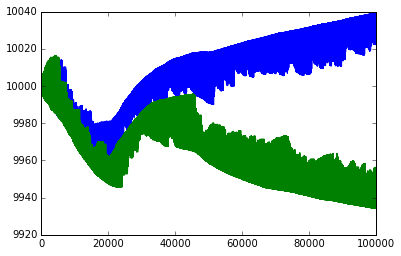

In [60]:
AM = TwoHFTMarket()
AM.main(100, 100000)

In [61]:
import random as r

namelist=['apple','grape','orange','lemon','banana']

class node:
    def __init__(self, name, children):
        self.name = name  # String
        self.children = children  # List of Class node

    def display(self, indent = 0):
        if self.children != None:
            print(' '*indent)+self.name
            for c in self.children:
                c.display(indent+1)
        else:
            print(' '*indent)+self.name

        

def maketree(maxdepth):
    if (maxdepth > 0):
        children = [ maketree(maxdepth-1) for i in range(2) ]
    else:
        children = None

    rootnode = node(r.choice(namelist),children)
    return rootnode

In [62]:
t = maketree(5)
t.display()

apple
 apple
  grape
   grape
    orange
     banana
     lemon
    banana
     lemon
     orange
   apple
    apple
     apple
     lemon
    banana
     lemon
     grape
  grape
   banana
    banana
     banana
     apple
    orange
     grape
     apple
   grape
    grape
     banana
     grape
    lemon
     banana
     grape
 lemon
  lemon
   apple
    lemon
     lemon
     banana
    orange
     apple
     grape
   grape
    banana
     apple
     banana
    banana
     apple
     banana
  lemon
   apple
    grape
     grape
     apple
    banana
     apple
     grape
   grape
    orange
     lemon
     apple
    banana
     grape
     lemon
